In [1]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
import matplotlib.pylab as plt
import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

2023-08-15 12:40:56.389111: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-15 12:40:57.464189: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224


model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

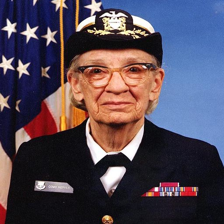

In [10]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES, IMAGE_RES))
grace_hopper 

In [14]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [15]:
result = model.predict(grace_hopper[np.newaxis, ...])
result.shape

1/1 [==============================] - 2s 2s/step


(1, 1280)

In [16]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

476

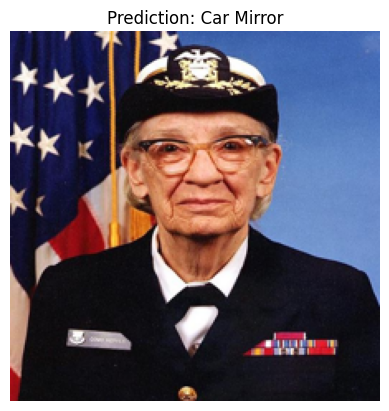

In [17]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [18]:
(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:80%]', 'train[80%:]'],
)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

In [19]:
for i, example_image in enumerate(train_examples.take(3)):
  print("Image {} shape: {}".format(i+1, example_image[0].shape))

Image 1 shape: (262, 350, 3)
Image 2 shape: (409, 336, 3)
Image 3 shape: (493, 500, 3)


2023-08-15 12:45:16.701812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [7]
	 [[{{node Placeholder/_0}}]]
2023-08-15 12:45:16.702719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [7]
	 [[{{node Placeholder/_3}}]]


In [20]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches      = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [21]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

2023-08-15 12:45:21.166627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [7]
	 [[{{node Placeholder/_1}}]]
2023-08-15 12:45:21.167944: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [7]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 40ms/step


IndexError: index 1059 is out of bounds for axis 0 with size 1001

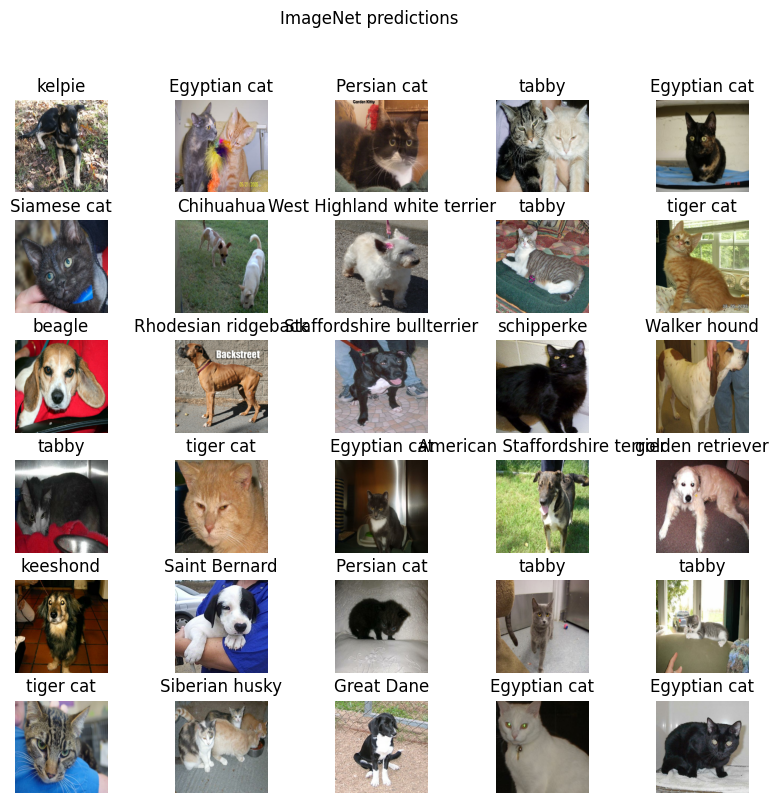

In [12]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [22]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL, input_shape=(IMAGE_RES, IMAGE_RES,3))

feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

feature_extractor.trainable = False

(32, 1280)


In [23]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(2, name='output_layer')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 output_layer (Dense)        (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [24]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 1
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

2023-08-15 12:46:03.608367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [7]
	 [[{{node Placeholder/_0}}]]
2023-08-15 12:46:03.608946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [7]
	 [[{{node Placeholder/_3}}]]
2023-08-15 12:46:04.616462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/zeros_like/StatefulPartitionedCall' with dtype

  1/582 [..............................] - ETA: 1:04:34 - loss: 0.8253 - accuracy: 0.4688

2023-08-15 12:46:10.140759: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 13/582 [..............................] - ETA: 1:39 - loss: 0.5129 - accuracy: 0.7428

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 45/582 [=>............................] - ETA: 1:33 - loss: 0.2196 - accuracy: 0.9035

 55/582 [=>............................] - ETA: 1:31 - loss: 0.1959 - accuracy: 0.9165

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


127/582 [=====>........................] - ETA: 1:19 - loss: 0.1257 - accuracy: 0.9510

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


335/582 [================>.............] - ETA: 43s - loss: 0.0753 - accuracy: 0.9718

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


348/582 [================>.............] - ETA: 40s - loss: 0.0733 - accuracy: 0.9725

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


359/582 [=================>............] - ETA: 38s - loss: 0.0725 - accuracy: 0.9730

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


386/582 [==================>...........] - ETA: 34s - loss: 0.0690 - accuracy: 0.9743

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


392/582 [===================>..........] - ETA: 33s - loss: 0.0685 - accuracy: 0.9744

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0594 - accuracy: 0.9784

2023-08-15 12:47:54.609309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [2]
	 [[{{node Placeholder/_3}}]]
2023-08-15 12:47:54.612312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [2]
	 [[{{node Placeholder/_3}}]]
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 140s 229ms/step - loss: 0.0594 - accuracy: 0.9784 - val_loss: 0.0392 - val_accuracy: 0.9873


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

In [17]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

1/1 [==============================] - 0s 411ms/step


array(['dog', 'cat', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'cat',
       'cat', 'dog', 'dog', 'dog', 'cat', 'dog', 'cat', 'cat', 'cat',
       'dog', 'dog', 'dog', 'dog', 'cat', 'cat', 'cat', 'cat', 'cat',
       'dog', 'cat', 'cat', 'cat', 'dog'], dtype='<U3')

In [18]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [1 0 0 0 0 0 1 1 0 0 1 1 1 0 1 0 0 0 1 1 1 1 0 0 0 0 0 1 0 0 0 1]
Predicted labels:  [1 0 0 0 0 0 1 1 0 0 1 1 1 0 1 0 0 0 1 1 1 1 0 0 0 0 0 1 0 0 0 1]


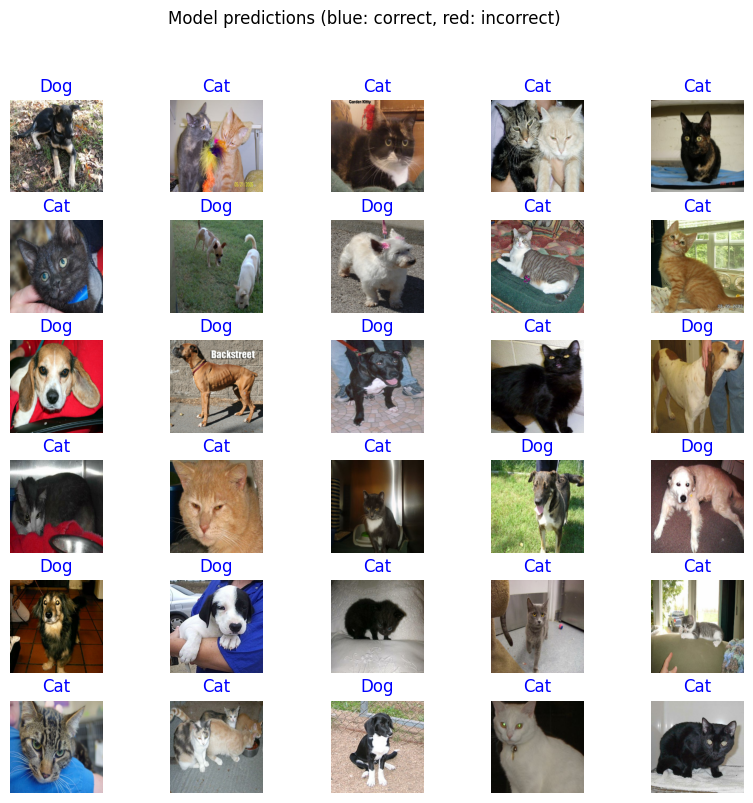

In [19]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

In [25]:
export_path_keras = "./cat-dog-model.h5"
model.save(export_path_keras)

In [26]:
reloaded = tf.keras.models.load_model(
  export_path_keras, 
  # `custom_objects` tells keras how to load a `hub.KerasLayer`
  custom_objects={'KerasLayer': hub.KerasLayer})

reloaded.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 output_layer (Dense)        (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [27]:
history = reloaded.fit(train_batches,
                    epochs=1,
                    validation_data=validation_batches)

2023-08-15 12:49:47.602251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/zeros_like/StatefulPartitionedCall' with dtype float and shape [?,1,1,1280]
	 [[{{node gradients/zeros_like/StatefulPartitionedCall}}]]
2023-08-15 12:49:47.602346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall' with dtype float and shape [?,7,7,1280]
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall}}]]
2023-08-15 12:49:47.602407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

 13/582 [..............................] - ETA: 1:38 - loss: 0.0308 - accuracy: 0.9904

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 45/582 [=>............................] - ETA: 1:33 - loss: 0.0355 - accuracy: 0.9889

 55/582 [=>............................] - ETA: 1:31 - loss: 0.0331 - accuracy: 0.9892

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


127/582 [=====>........................] - ETA: 1:19 - loss: 0.0361 - accuracy: 0.9894

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


335/582 [================>.............] - ETA: 43s - loss: 0.0311 - accuracy: 0.9895

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


348/582 [================>.............] - ETA: 40s - loss: 0.0310 - accuracy: 0.9893

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


359/582 [=================>............] - ETA: 38s - loss: 0.0307 - accuracy: 0.9894

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


386/582 [==================>...........] - ETA: 34s - loss: 0.0301 - accuracy: 0.9896

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


392/582 [===================>..........] - ETA: 33s - loss: 0.0301 - accuracy: 0.9896

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0295 - accuracy: 0.9899

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 135s 222ms/step - loss: 0.0295 - accuracy: 0.9899 - val_loss: 0.0305 - val_accuracy: 0.9912


In [28]:
# save as SavedModel
export_path_sm = "./models"
tf.saved_model.save(model, export_path_sm)

In [31]:
# load the SavedModel
reloaded_sm = tf.saved_model.load(export_path_sm)
